In [8]:
from cmath import cos
from inspect import _void
import math
from sys import flags
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import scipy.signal as spsg
import os
from sklearn.cluster import KMeans
from scipy.spatial import distance
import time
import mat73
import os
from os.path import join
import pickle

# pyclustering kmeans
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder




TMAX = 111 # Length of time series
NREGIONS = 82
triu_idx = np.triu_indices(NREGIONS,1)
basePath = "tDCS_timeseries"
awakePath = join(basePath, "timeseries_CoCoMac_tDCS_awake")
anesthPath = join(basePath, "timeseries_CoCoMac_tDCS_anesthesia")



In [9]:
# Angular difference function
def adif(a, b):
    return 2*math.pi-abs(a-b) if abs(a-b)>math.pi else abs(a-b) # HAY QUE AGREGAR EL COSENO DEPSPUES Y PONER EN 0 LA DIAGONAL
vec_adif = np.vectorize(adif,otypes=[np.ndarray])
def map_adif(t0xn):
    """ Takes a timepoint of all the nodes and generates the phase differenes for all of them
    Parameters
    ----------
    t0xn: np.array(1,N)
        One timesample of an original nodesxsteps timeseries
    Returns
    ----------
    np.array(N,N)
        NxN matrix of phase differences
    """    
    tmp = np.array(list(map(lambda node: np.cos(vec_adif(t0xn,node).astype(float)),t0xn)))            
    tmp = (tmp.T - np.eye(NREGIONS)).T    
    return tmp
    
def create_phase_dif(tss):
    """ Takes a whole trial and generates the phases differences for all timepointss
    Parameters
    ----------
    tss: np.array(M,N,T)
        A dataset of M trails of T steps registiring N channels or nodes
    Returns
    ----------
    np.array(M,N,N,T)
        MxNxNxT matrix of phase differences
        
    """
    return np.array(list(map(map_adif, tss)))
def flatten_matrices(tss):
    """ Flattens the dataset
    Parameters
    ---------
    tss: np.array(M,N,N,T)
        MxNxNxT dataset
    Returns
    ---------
    np.array(M*subdiag,T)
        All trials are concatenated and their upper triangular submatrices flattened
    """
    triu_idx = np.triu_indices(tss.shape[1],1)
    res = tss[:,triu_idx[0],triu_idx[1],:].swapaxes(1,2) # Change regions axis to time axis
    res = res.reshape((res.shape[0]*res.shape[1],res.shape[2])) # So we can pile trials x time
    return res

def reestructure_matrix(snapshot):    
    """ Recovers symetric phase difference matrix
    Parameters
    ----------
    snapshot: np.array(F)
        Flattened superior triangular matrix of a phase difference matrix
    Returns
    res: np.array(NREGIONS,NREGIONS)
        The original symetric matrix from which the flattned snapshot was captured
    """
    triu_idx = np.triu_indices(NREGIONS,1)    
    nxn_matrix_symmetric = np.zeros((NREGIONS,NREGIONS))
    nxn_matrix_symmetric[triu_idx[0],triu_idx[1]] = snapshot
    nxn_matrix_symmetric += nxn_matrix_symmetric.T
    return nxn_matrix_symmetric

def reestructure_dataset(proccessed_tss):
    """ Assumes the input is a set of trials processed as flattened phase differences and takes it back to trialsxNREGIONSxNREGIONSxTMAX    
    """
    n_trials = proccessed_tss.shape[0]//TMAX
    reestrctured = np.zeros((n_trials,NREGIONS,NREGIONS,TMAX))
    for i_trial in range(n_trials):
        for t in range(TMAX):
            reestrctured[i_trial,:,:,t] = reestructure_matrix(proccessed_tss[(i_trial*TMAX)+t,:])
    return reestrctured

def get_instant_phases(ts_all):    
    ts_all_zscored = np.zeros((len(ts_all),ts_all.shape[1],ts_all.shape[2])) # Storage for z-scored filtered signals
    for i in range(len(ts_all)):
        ts_all_zscored[i]=np.array(stats.zscore(ts_all[i],axis=1))
        ts_all_zscored[i] = spsg.detrend(ts_all_zscored[i],type='linear')
        ts_all_zscored[i] = ts_all_zscored[i]-np.mean(ts_all_zscored[i])    
    signal = np.array(ts_all_zscored)

    # Reverse the signal, and Concatenation from both sides.
    signal_rev = np.flip(signal, axis=2)
    signal_rev_concat = np.concatenate((signal_rev, signal, signal_rev), axis=2)
    # Butterworth filter parameters
    n_order = 2
    TR = 2.4 # in seconds
    fnq = 1/(2*TR) # Nyquist frequency
    low_f = 0.0025 # lower cutoff for bandpass filter
    high_f = 0.05 # upper cutoff for bandpass filter
    Wn = [low_f/fnq,high_f/fnq]
    b,a = spsg.iirfilter(n_order,Wn,btype='bandpass',ftype='butter', output='ba')
    # Apply Butterworth filter
    filt_ts = np.empty_like(signal_rev_concat)
    #for i in range(len(ts_all_zscored)): # NOT NECESSARY 
    #    filt_ts = spsg.filtfilt(b,a,signal_rev_concat,axis=1, padtype='odd', padlen=3*(max(len(b),len(a))-1))
    filt_ts = spsg.filtfilt(b,a,signal_rev_concat,axis=1, padtype='odd', padlen=3*(max(len(b),len(a))-1))

    # Now we can cut the signal back to its original size by taking the middle part
    signal_filtered = filt_ts[:,:,len(signal_rev[0][0]):len(signal_rev[0][0])+len(signal[0][0])]

    # And we can demean it again
    signal_filtered = signal_filtered - np.mean(signal_filtered, axis=2, keepdims=True)


    # Analytical continuation of our signal
    analytic_signal = spsg.hilbert(signal_filtered)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal)) # Unwrap doesn't do anything?
    # signal_reconstr = amplitude_envelope*np.cos(instantaneous_phase) # To ensure that we can reconstruct our initial signal from the hilbert transform
    return instantaneous_phase
def get_vectoried(input_phase):
    # Now we can calculate the phase difference between each pair of regions using the adif function
    # We will store the phase differences in a matrix of size (n_regions, n_regions, n_timepoints)
    phase_diff_tmp = np.zeros((len(input_phase),len(input_phase[0]),len(input_phase[0]),len(input_phase[0][0])))
    for ind in range(len(input_phase)):
        for t in range(len(input_phase[0][0])):
            for i in range(len(input_phase[0])):
                for j in range(len(input_phase[0])):
                    if i==j:
                        phase_diff_tmp[ind,i,j,t] = 0
                    else:
                        phase_diff_tmp[ind,i,j,t] = np.cos(adif(input_phase[ind][i][t], input_phase[ind][j][t]))

    # Quite lengthy operation: hate those for loops :'(
    # Find a way through numpy array handling

    # y = int(len(input_phase)*len(input_phase[0][0][0]))
    # x = int(len(input_phase[0][0])/2*(len(input_phase[0][0])-1))
    # Vectorize the superior triangular
    vector_size = len(np.triu_indices(input_phase.shape[1],1)[0])
    
    vectorized = np.zeros((vector_size,input_phase.shape[0]*input_phase.shape[2]))    
    for ind in range(len(input_phase)):
        for t in range(len(input_phase[0][0])):
            temp = np.array(())
            for j in range(len(input_phase[0])):
                for i in range(len(input_phase[0])):
                    if i>j:
                        temp = np.append(temp,phase_diff_tmp[ind,i,j,t])        
            vectorized[:,(ind*input_phase.shape[2])+t] = temp

    vectorized = vectorized.T
    return vectorized



def get_phases(input_phase):
    # Now we can calculate the phase difference between each pair of regions using the adif function
    # We will store the phase differences in a matrix of size (n_regions, n_regions, n_timepoints)
    phase_diff_tmp = np.zeros((len(input_phase),len(input_phase[0]),len(input_phase[0]),len(input_phase[0][0])))
    for ind in range(len(input_phase)):
        for t in range(len(input_phase[0][0])):
            for i in range(len(input_phase[0])):
                for j in range(len(input_phase[0])):
                    if i==j:
                        phase_diff_tmp[ind,i,j,t] = 0
                    else:
                        phase_diff_tmp[ind,i,j,t] = np.cos(adif(input_phase[ind][i][t], input_phase[ind][j][t]))
    return phase_diff_tmp

import multiprocessing as mp
def process_parallelized(data):
    n_proc = mp.cpu_count()
    chunk_size = data.shape[0]//n_proc
    proc_chunks = []
    for i_proc in range(n_proc):
        chunkstart = i_proc*chunk_size
        chunkend = (i_proc+1)*chunk_size if i_proc < n_proc -1 else None
        proc_chunks.append(data[chunkstart:chunkend, :, :])

    assert sum(map(len,proc_chunks)) == data.shape[0]
    if __name__=='__main__':
        def process_chunk(proc_chunk):
            chunk_res = np.array(list(map(map_adif, proc_chunk)))    
            chunk_res.index = proc_chunk.index
            return chunk_res
        with mp.Pool(processes=n_proc) as pool:
            proc_results = [pool.apply_async(process_chunk,args=(chunk,)) for chunk in proc_chunks]
            result_chunks = [r.get() for r in proc_results]
    return result_chunks



#inst_ph = get_instant_phases(awake_experiments['anesthesia'])
#vectorized_dif_ph = create_phase_dif(inst_ph)

# Read data

In [10]:
experiment_names = {s: [] for s in ["baseline_awake", "awake", "baseline_anesthesia", "anesthesia"]}
for i,fname in enumerate(os.listdir(awakePath)):
    name = fname.split("_")[4:] # First 3 words are timeseries - monkeyname - date
    exp_type = ("_").join(name[:-1])    
    if exp_type not in ["baseline_awake", "anesthesia"]:
        continue
    experiment_names[exp_type].append((fname,i))
for i,fname in enumerate(os.listdir(anesthPath)):
    name = fname.split("_")[4:] # First 3 words are timeseries - monkeyname - date
    exp_type = ("_").join(name[:-1])
    if exp_type not in ["awake", "baseline_anesthesia"]:
        continue
    experiment_names[exp_type].append((fname,i))

116

In [16]:
awakeFnames = os.listdir(awakePath)
anesthFnames = os.listdir(anesthPath)
ts_all = np.zeros((len(experiment_names["baseline_awake"])+len(experiment_names["awake"])+
                   len(experiment_names["baseline_anesthesia"])+len(experiment_names["anesthesia"]),
                   NREGIONS,TMAX))
for j,fn in enumerate(experiment_names["baseline_awake"]+experiment_names["anesthesia"]):    
    tmp = loadmat(join(awakePath,fn[0]))
    ts_all[j, :, :] = np.swapaxes(tmp['scans'][:TMAX,:],0,1) 
for i,fn in enumerate(experiment_names["baseline_anesthesia"]+experiment_names["awake"]):    
    tmp = loadmat(join(anesthPath,fn[0]))
    ts_all[i+len(experiment_names["baseline_awake"]+experiment_names["anesthesia"]), :, :] = np.swapaxes(tmp['scans'][:TMAX,:],0,1) 
ts_all = flatten_matrices(create_phase_dif(get_instant_phases(ts_all)))

115


## Read data separated by condition

In [18]:

experiments = {}.fromkeys(experiment_names.keys())
for exp_type in experiments.keys():
    data = np.zeros((len(experiment_names[exp_type]),NREGIONS,NREGIONS,TMAX))
    pre_data = np.zeros((len(experiment_names[exp_type]),len(triu_idx[0])))
    for i,fname in enumerate(experiment_names[exp_type]):        
        #tmp = loadmat(join(awakePath,fname[0]))        
        pre_data[i] = ts_all[fname[1]]
    experiments[exp_type] = pre_data
    



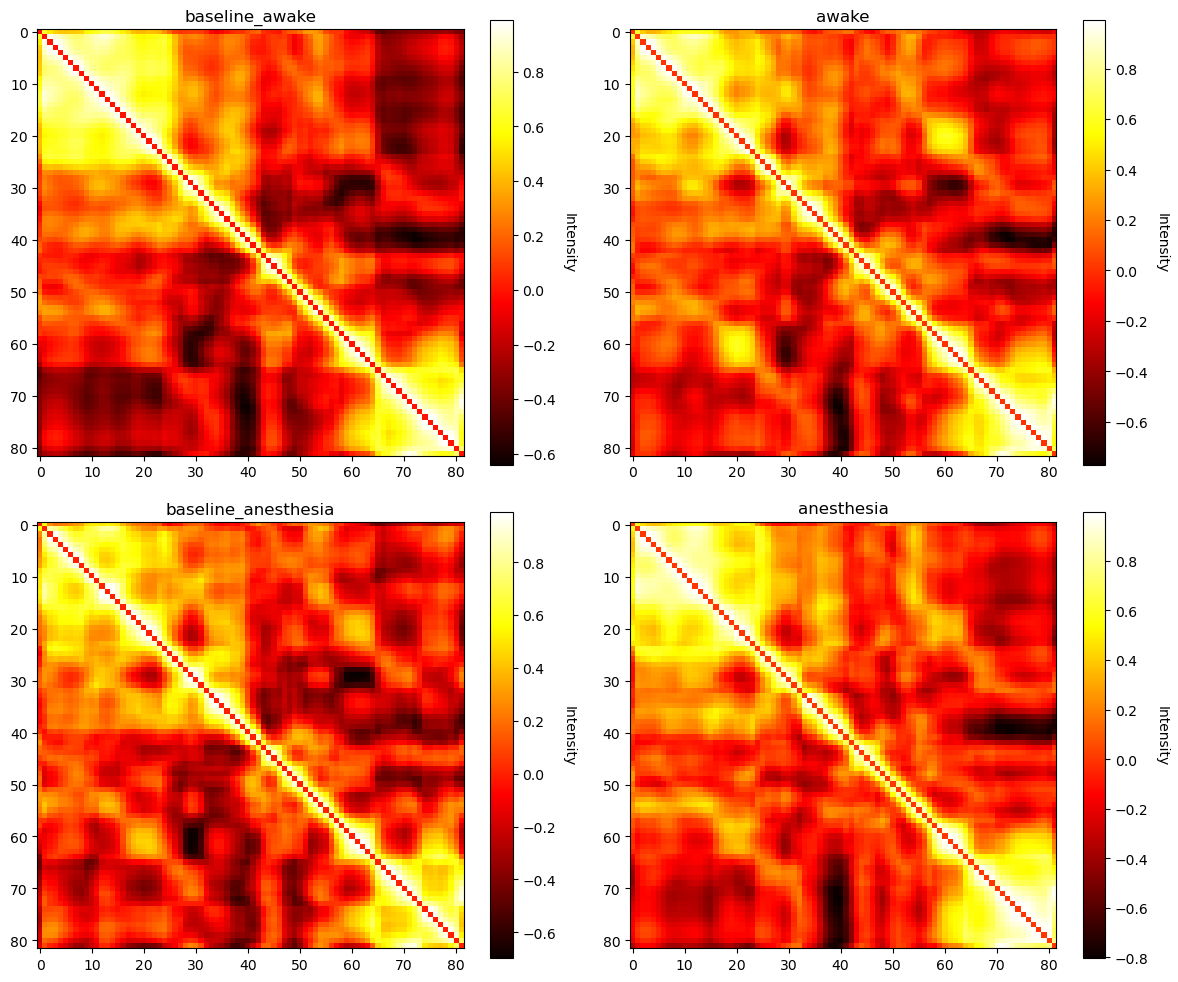

In [21]:
from math import ceil, sqrt

num_plots = len(experiments)
num_cols = ceil(sqrt(num_plots))
num_rows = ceil(num_plots / num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))
# Plot each centroid on a separate subplot
fcs = np.zeros((len(experiments),NREGIONS,NREGIONS))
for i,exp_type in enumerate(experiments.keys()):
    
    row = i // num_cols
    col = i % num_cols    
    fc = np.mean(np.apply_along_axis(reestructure_matrix,1,experiments[exp_type]),0)
    im = axs[row,col].imshow(fc, cmap='hot')
    fcs[i,:,:] = fc
    # Set the title for this subplot
    axs[row,col].set_title(exp_type)
    # Add a colorbar to show the heatmap values
    cbar = axs[row,col].figure.colorbar(im, ax=axs[row,col])
    cbar.ax.set_ylabel('Intensity', rotation=-90, va="bottom")
    
# Adjust the layout of the subplots
plt.tight_layout()

# Show the figure
plt.show()
if not os.path.exists("plots/JustWakeAnesth"):
    os.mkdir("plots/JustWakeAnesth")
fig.savefig(f"plots/JustWakeAnesth/FCs_anesth.png")

In [23]:
### Save data
with open('data_processed.pkl', 'wb') as f:
    pickle.dump(experiments,f)
with open("data_processed.pkl", 'rb') as f:
    experiments_save = pickle.load(f)


# Do K means

In [24]:
distance_measures = {'euclidean': 0, 'squared euclidean': 1, 'manhattan': 2, 'chebyshev': 3, 
                    'canberra': 5, 'chi-square': 6}

In [25]:
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmeans import kmeans, kmeans_observer, kmeans_visualizer

In [26]:
# TSCM K-Means
# AW+OFF+ON5V
labels = ()
centroids = ()
sse_values_high = []
for k in range(2,8):
    print(k)
    #kmeans = KMeans(n_clusters=k, random_state=1, n_init=500,init='random').fit(vectorized)
    #labels = kmeans.labels_
    #centroids_selv_pp = kmeans.cluster_centers_
    #np.save('TSCM_DBS_centroids k='+ str(k), centroids_selv_pp)    
    #np.save('TSCM_DBS_labels k='+ str(k), labels)

    initial_centers = random_center_initializer(ts_all, k, random_state=5).initialize()
    observer = kmeans_observer()
    instanceKm = kmeans(ts_all, observer=observer,initial_centers=initial_centers, metric=distance_metric(2))
    instanceKm.process()
    sse_values_high.append(instanceKm.get_total_wce())
    clusteroids = instanceKm.get_clusters()
    centroids = instanceKm.get_centers()
    # enumerate encoding type to index labeling to get labels
    pyEncoding = instanceKm.get_cluster_encoding()
    pyEncoder = cluster_encoder(pyEncoding, clusteroids, ts_all)
    labels = pyEncoder.set_encoding(0).get_clusters()

    if not os.path.exists("Results/JustWakeAnesth"):
        os.mkdir("Results/JustWakeAnesth")
    with open(f"Results/JustWakeAnesth/k-{k}_centroids.pkl", 'wb') as f:
        pickle.dump(centroids, f)
    with open(f"Results/JustWakeAnesth/k-{k}_centroids.pkl", 'rb') as f:
        centroids = pickle.load(f)
    with open(f"Results/JustWakeAnesth/k-{k}_clusteroids.pkl", 'wb') as f:
        pickle.dump(clusteroids, f)
    with open(f"Results/JustWakeAnesth/k-{k}_clusteroids.pkl", 'rb') as f:
        clusteroids = pickle.load(f)
    with open(f"Results/JustWakeAnesth/k-{k}_Kmeans_model_pyclust.pkl", 'wb') as f:
        pickle.dump(instanceKm, f)
    with open(f"Results/JustWakeAnesth/k-{k}_Kmeans_model_pyclust.pkl", 'rb') as f:
        instanceKm = pickle.load(f)

plt.plot(range(2,8), sse_values_high, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

2


OSError: dlopen(/Users/ivanmindlin/miniforge3/envs/bstates/lib/python3.11/site-packages/pyclustering/core/64-bit/macos/libpyclustering.so, 0x0006): tried: '/Users/ivanmindlin/miniforge3/envs/bstates/lib/python3.11/site-packages/pyclustering/core/64-bit/macos/libpyclustering.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/ivanmindlin/miniforge3/envs/bstates/lib/python3.11/site-packages/pyclustering/core/64-bit/macos/libpyclustering.so' (no such file), '/Users/ivanmindlin/miniforge3/envs/bstates/lib/python3.11/site-packages/pyclustering/core/64-bit/macos/libpyclustering.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))

In [ ]:
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusteroids, ts_all)
visualizer.show()

kmeans_visualizer.show_clusters(sample, clusters, centers, start_centers)
kmeans_visualizer.animate_cluster_allocation(sample, observer)


# Plot centroids

In [17]:
k = 9
with open(f"Results/JustWakeAnesth/k-{k}_centroids.pkl", 'rb') as f:
    centroids = pickle.load(f)
with open(f"Results/JustWakeAnesth/k-{k}_clusteroids.pkl", 'rb') as f:
        clusteroids = pickle.load(f)
with open(f"Results/JustWakeAnesth/k-{k}_Kmeans_model_pyclust.pkl", 'rb') as f:
    instanceKm = pickle.load(f)

In [ ]:
awake_counts = {}
anesth_counts = {}

for k in range(2,8):
    with open(f"Results/JustWakeAnesth/k-{k}_clusteroids.pkl", 'rb') as f:
        clusteroids = pickle.load(f)
    anesth_exp_clust_counts = {i:np.zeros((TMAX,)) for i in range(len(ts_all))} 
    for clust_id, clusteroid in enumerate(clusteroids): # iterate all clusteroids
        for timestamp_id in clusteroid: # For each timestanp in the clusteroid list 
            anesth_exp_clust_counts[timestamp_id//len(ts_all)][timestamp_id%TMAX] = clust_id # Extract timeseries ID and correct time order and place the label
    
    anesth_ordered_counts = {}.fromkeys(anesth_experiment_names.keys())
    # Now we want them ordered by experiment type condition
    for exp_type in anesth_ordered_counts.keys(): 
        anesth_ordered_counts[exp_type] = np.zeros((len(anesth_experiment_names[exp_type]),TMAX)) # We're gonna store the labels for all trials 
        for i,fname in enumerate(anesth_experiment_names[exp_type]): # We extract fname that has the name and ID of the trial
            anesth_ordered_counts[exp_type][i, :] = anesth_exp_clust_counts[fname[1]] # For each trial we save its assigned labels for all timesteps

    anesth_counts[k] = anesth_ordered_counts 


    awake_exp_clust_counts = {i:np.zeros((TMAX,)) for i in range(len(ts_all))}#dict.fromkeys(awake_experiment_names.keys())
    for clust_id, clusteroid in enumerate(clusteroids):
        for timestamp_id in clusteroid:
            awake_exp_clust_counts[timestamp_id//len(ts_all)][timestamp_id%TMAX] = clust_id

    awake_ordered_counts = {}.fromkeys(awake_experiment_names.keys())
    # Now we want them ordered by experiment type condition
    for exp_type in awake_ordered_counts.keys(): 
        awake_ordered_counts[exp_type] = np.zeros((len(awake_experiment_names[exp_type]),TMAX)) # We're gonna store the labels for all trials 
        for i,fname in enumerate(awake_experiment_names[exp_type]): # We extract fname that has the name and ID of the trial
            awake_ordered_counts[exp_type][i, :] = awake_exp_clust_counts[fname[1]] # For each trial we save its assigned labels for all timesteps

    awake_counts[k] = awake_ordered_counts
    

In [ ]:
#centroids = np.load("./results/Fored/TS_ALL_centroids.npy")
triu_idx = np.triu_indices(NREGIONS,1)
tril_idx = np.tril_indices(NREGIONS,-1)
# Create a figure with 7 subplots arranged in a 2x4 grid
for k in range(2,8):
    num_plots = k
    num_cols = ceil(sqrt(num_plots))
    num_rows = ceil(num_plots / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    with open(f"Results/JustWakeAnesth/k-{k}_centroids.pkl", 'rb') as f:
        centroids = pickle.load(f)    

    # Plot each centroid on a separate subplot
    print("Plotting heatmaps")
    for i in range(k):
        # Choose the subplot for this centroid
        ax = axs.flatten()[i]
        
        # Plot the heatmap for this centroid
        im = ax.imshow(reestructure_matrix(centroids[i]), cmap='hot')
        # Set the title for this subplot
        ax.set_title('Centroid {}'.format(i+1))
        # Add a colorbar to show the heatmap values
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('Intensity', rotation=-90, va="bottom")
        
    # Adjust the layout of the subplots
    plt.tight_layout()

    # Show the figure
    plt.show()
    fig.savefig(f"plots/JustWakeAnesth/{k}centroids.png")
    # With pyclustering output 
    # This is basically an intersect between set of ids for each exp type and each clusteroid. The result of the seven intersections if what I want
            

In [ ]:
from collections import defaultdict
from math import ceil, sqrt
counter = defaultdict(int)
for k in range(2,8):
    num_plots = len(awake_exp_clust_counts)
    num_cols = ceil(sqrt(num_plots))
    num_rows = ceil(num_plots / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))

    for i,exp_type in enumerate(awake_exp_clust_counts.keys()):
        #cur_labels = [single_label for trial_labels in exp_results[Fored/exp_type] for single_label in trial_labels]
        row = i // num_cols
        col = i % num_cols
        cur_labels = awake_exp_clust_counts[k][exp_type].flatten()
        #for label in cur_labels:
        #    counter[label]+=1
        weights = np.ones_like(cur_labels) / len(cur_labels)
        offset = 0.5
        bins = np.linspace(-offset, k-offset, k+1)
        # Generate a histogram plot of the predicted values on the appropriate subplot
        axs[row,col].hist(cur_labels, weights=weights, bins=bins, rwidth=0.75)
        axs[row,col].set_xticks(range(k))
        axs[row,col].set_title(exp_type)
        axs[row,col].set_xlabel('Cluster')
        axs[row,col].set_ylabel('Frequency')
        #axs[i].set_ylim(0,0.35)

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Show the figure
    plt.show()
    fig.savefig(f"plots/JustWakeAnesth/distributions_{k}clusters_awake.png")


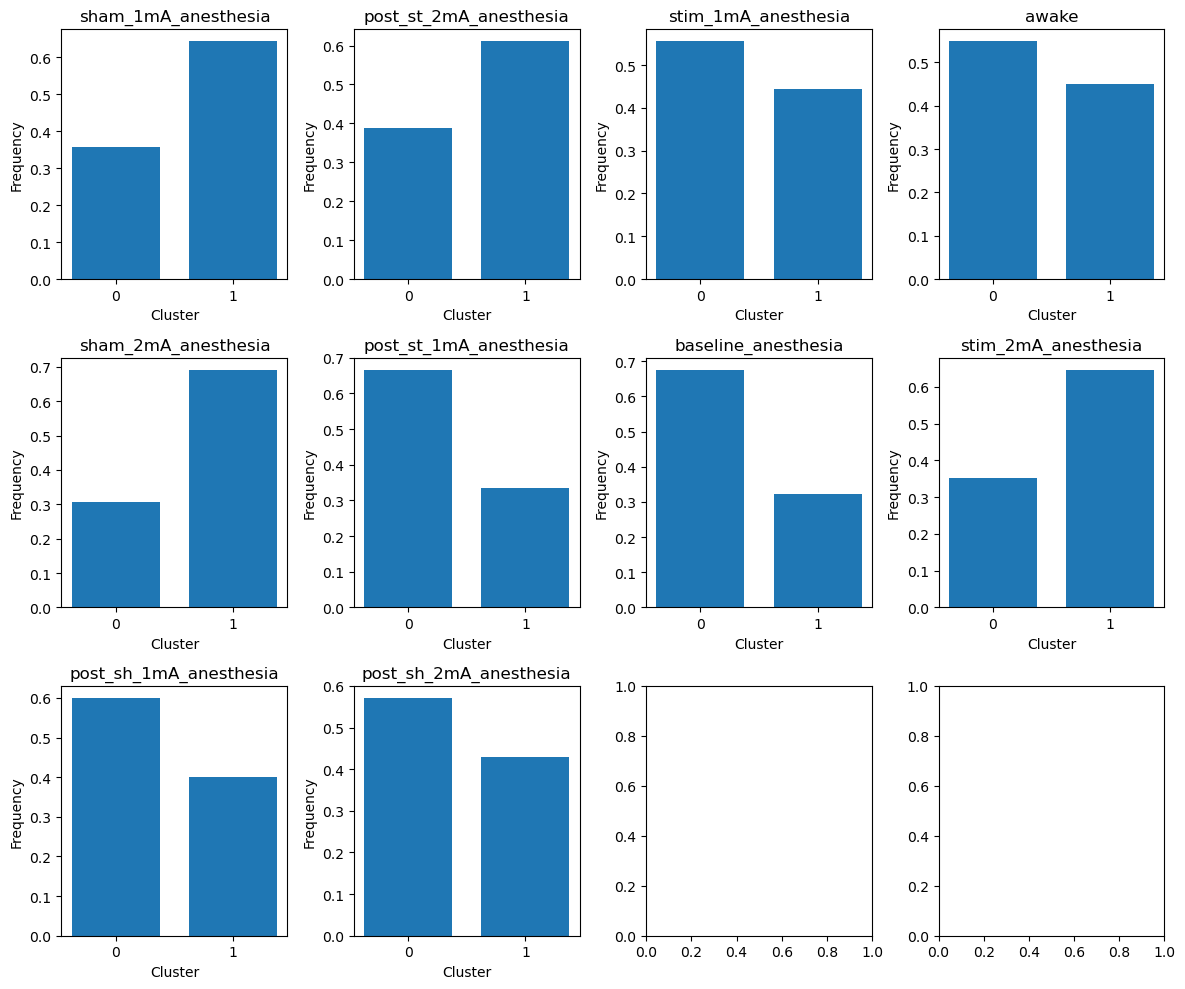

In [157]:
from collections import defaultdict
from math import ceil, sqrt
counter = defaultdict(int)


num_plots = len(anesth_exp_clust_counts)
num_cols = ceil(sqrt(num_plots))
num_rows = ceil(num_plots / num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))

for i,exp_type in enumerate(anesth_exp_clust_counts.keys()):
    #cur_labels = [single_label for trial_labels in exp_results[exp_type] for single_label in trial_labels]
    row = i // num_cols
    col = i % num_cols
    cur_labels = anesth_exp_clust_counts[exp_type]
    for label in cur_labels:
        counter[label]+=1
    weights = np.ones_like(cur_labels) / len(cur_labels)
    offset = 0.5
    bins = np.linspace(-offset, k-offset, k+1)
    # Generate a histogram plot of the predicted values on the appropriate subplot
    axs[row,col].hist(cur_labels, weights=weights, bins=bins, rwidth=0.75)
    axs[row,col].set_xticks(range(k))
    axs[row,col].set_title(exp_type)
    axs[row,col].set_xlabel('Cluster')
    axs[row,col].set_ylabel('Frequency')
    #axs[i].set_ylim(0,0.35)

# Adjust the layout of the subplots
plt.tight_layout()

# Show the figure
plt.show()
fig.savefig(f"plots/JustWakeAnesth/distributions_{k}clusters_anesth.png")

In [116]:
counter

defaultdict(int, {4: 49, 6: 38, 1: 49, 0: 32, 5: 34, 3: 32, 2: 9})

In [120]:
h

array([0.14285714, 0.28571429, 0.        , 0.14285714, 0.21428571,
       0.21428571])

In [121]:
b

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5])

In [ ]:
centroids = np.load("TSCM_DBS_centroids k=7.npy")
triu_idx = np.triu_indices(NREGIONS,1)
tril_idx = np.tril_indices(NREGIONS,-1)
# Create a figure with 7 subplots arranged in a 2x4 grid
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Plot each centroid on a separate subplot
for i in range(7):
    # Choose the subplot for this centroid
    ax = axs.flatten()[i]
    centroid_matrix = np.ones((NREGIONS,NREGIONS))*np.min(centroids[i])
    centroid_matrix[triu_idx[0],triu_idx[1]] = centroids[i]
    centroid_matrix[tril_idx[0],tril_idx[1]] = centroids[i]
    # Plot the heatmap for this centroid
    im = ax.imshow(centroid_matrix, cmap='hot')
    # Set the title for this subplot
    ax.set_title('Centroid {}'.format(i+1))
    # Add a colorbar to show the heatmap values
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Intensity', rotation=-90, va="bottom")
    
# Adjust the layout of the subplots
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
# With sklearn output
exp_results = {}
for i,fname in enumerate(ts_names):
    name = fname.split("_")[4:] # First 3 words are timeseries - monkeyname - date
    exp_type = ("_").join(name[:-1])
    print(exp_type)
    if exp_type not in exp_results.keys():
        exp_results[exp_type] = []
    cur_trial_labels = labels[i*111:(i+1)*111]
    exp_results[exp_type].append(cur_trial_labels)

In [14]:
Time_per_rec = len(ts_all[0][0])
N=len(ts_all[0])
Total_patient = len(ts_all)
Leading_Eig = np.empty((Total_patient*Time_per_rec,N))
for ind in range(Total_patient):
    for t in range(Time_per_rec):
            eigenvalues, eigenvectors = np.linalg.eig(phase_diff[ind,:,:,t])
            
            V1 = eigenvectors[:, np.argmax(eigenvalues)]
            
            mean_positive = np.mean(V1 > 0)

            if mean_positive > 0.5:
                V1 = -V1
            elif mean_positive == 0.5 and np.sum(V1[V1 > 0]) > -np.sum(V1[V1 < 0]):
                V1 = -V1
            Leading_Eig[Time_per_rec*ind+t] = V1

/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
